In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Goal: PREDICT THE NUMBERS FOR EACH COUNTRIES REFUGEES

### This actually shows some interesting trends, of course the data all follow the same basic curves, since they are all subgroups of Refugees. Already this data seems sparse.

# Looking at a single country over time

In [11]:
ls data/

GemDataEXTR.zip
affirmative_asylum.csv
asylum_statistics.csv
defensive_asylum.csv
factbook.db
refugee_statistics.csv
refugee_status.csv
unhcr_popstats_export_demographics_all_data.csv
unhcr_popstats_export_time_series_all_data.csv


In [5]:
def one_country(data,country):
    #for a single country get everything
    country_df = data[data['Country or territory of asylum or residence'] == country]
    return(country_df)

# Looking at all countries, setting a maximum threshold to inspect the range of refugees

In [6]:
def plot_all_countries(data,threshold):
    plt.figure(figsize=(20,10))
    countries = data['Country or territory of asylum or residence']
    countries = countries.unique()
    for i in countries:
        country = data[data['Country or territory of asylum or residence']==i]
        if max(country['Refugees'])<threshold:
            plt.plot(country['Year'],country['Refugees'],label = str(i).decode('utf-8'))
            plt.legend()
        else:
            break

In [7]:
plot_all_countries(data_2,500000)

NameError: name 'data_2' is not defined

# Okay, maybe just do this: Starting with separating out the countries start looking at the projections for next year for both the origin and the relocated place. 

#### Trying Linear Regression

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
lr = LinearRegression()
X = by_year['Year']
y = by_year['Refugees']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)
lr.fit(X_train[:,np.newaxis], y_train)
y_predict= lr.predict(X_test[:,np.newaxis])
plt.plot(y_test,y_predict,'.')
plt.plot(np.linspace(0,10000000),np.linspace(0,10000000))
plt.xlim(0.6*10**7)
plt.ylim(0.6*10**7)
plt.show()

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'by_year' is not defined

The issue is that I have like, no data points for each origin country this way. i'd have too many distinct places otherwise for each place. Each origin has 15 time series points. But the combination of the origin and place of asylum is richer. There is something to that...

In [9]:
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot
lag_plot(by_year['Value'])
pyplot.show()

NameError: name 'by_year' is not defined

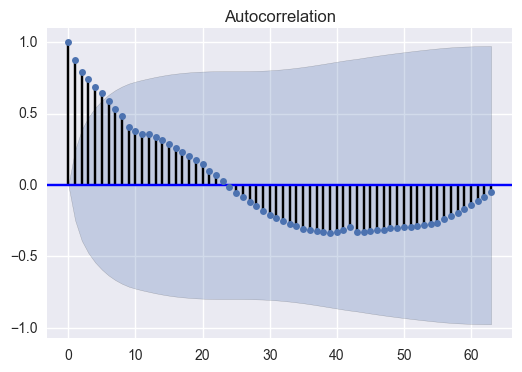

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(by_year['Value'])
pyplot.show()

In [ ]:
# from sklearn.metrics import mean_squared_error
# # create lagged dataset
# values = pd.DataFrame(by_year['Refugees'].values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't+1']
# # split into train and test sets
# X = dataframe.values
# train, test = X[1:len(X)-7], X[len(X)-7:]
# train_X, train_y = train[:,0], train[:,1]
# test_X, test_y = test[:,0], test[:,1]
 
# # persistence model
# def model_persistence(x):
# 	return x
 
# # walk-forward validation
# predictions = list()
# for x in test_X:
# 	yhat = model_persistence(x)
# 	predictions.append(yhat)
# test_score = mean_squared_error(test_y, predictions)
# print('Test MSE: %.3f' % test_score)
# # plot predictions vs expected
# pyplot.plot(test_y)
# pyplot.plot(predictions, color='red')
# pyplot.show()

# Autoregression Model

In [ ]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
series = by_year['Refugees']
# split dataset
X = series.values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
## Trying to figure out LSTMs

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = by_year[['Refugees']]
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),'k')
plt.plot(trainPredictPlot,'b')
plt.plot(testPredictPlot,'r')
plt.show()

## Trying time series analysis on more data

In [3]:
ls data/

affirmative_asylum.csv
asylum_statistics.csv
defensive_asylum.csv
refugee_statistics.csv
refugee_status.csv
unhcr_popstats_export_time_series_all_data.csv


In [12]:
data_2= pd.read_csv('./data/unhcr_popstats_export_time_series_all_data.csv',parse_dates=['Year'])
data_2['Year'] = data_2['Year'].apply(lambda x: x.year)
data_2.dropna(axis = 0,inplace = True)
def if_numeric(val):
    try:
        return(int(val))
    except:
        return(np.nan)
data_2['Value'] = data_2['Value'].apply(if_numeric)
data_2.head()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000.0
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000.0
2,1951,Belgium,Various/Unknown,Refugees (incl. refugee-like situations),55000.0
3,1951,Canada,Various/Unknown,Refugees (incl. refugee-like situations),168511.0
4,1951,Switzerland,Various/Unknown,Refugees (incl. refugee-like situations),10000.0


In [13]:
data_2

,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000.0
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000.0
2,1951,Belgium,Various/Unknown,Refugees (incl. refugee-like situations),55000.0
3,1951,Canada,Various/Unknown,Refugees (incl. refugee-like situations),168511.0
4,1951,Switzerland,Various/Unknown,Refugees (incl. refugee-like situations),10000.0
5,1951,Germany,Various/Unknown,Refugees (incl. refugee-like situations),265000.0
6,1951,Denmark,Various/Unknown,Refugees (incl. refugee-like situations),2000.0
7,1951,Spain,Various/Unknown,Refugees (incl. refugee-like situations),2000.0
8,1951,France,Various/Unknown,Refugees (incl. refugee-like situations),290000.0
9,1951,United Kingdom,Various/Unknown,Refugees (incl. refugee-like situations),208000.0


In [14]:
data_2.dropna(axis = 0,inplace = True)

In [15]:
# pd.to_numeric(data_2['Value'])
data_2.shape
data_2.describe()

,Year,Value
count,155128.000000,1.551280e+05
mean,2005.253114,5.618802e+03
std,7.443237,7.967549e+04
min,1951.000000,-1.000000e+00
25%,2002.000000,2.000000e+00
50%,2007.000000,9.000000e+00
75%,2011.000000,8.800000e+01
max,2014.000000,9.799410e+06


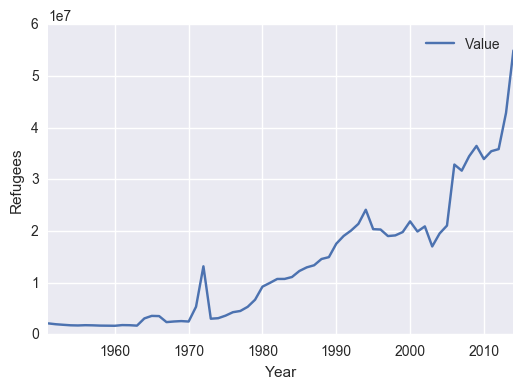

In [16]:
by_year = data_2.groupby(u'Year')['Value'].sum()
by_year = by_year.reset_index()
by_year.plot('Year','Value')
plt.ylabel('Refugees')

In [17]:
def plot_all_countries(data,threshold):
    plt.figure(figsize=(20,10))
    countries = data['Country / territory of asylum/residence']
    countries = countries.unique()
    for i in countries:
        country = data[data['Country / territory of asylum/residence']==i]
        if max(country['Value'])<threshold:
            plt.plot(country['Year'],country['Value'],label = str(i).decode('utf-8'))
            plt.legend()
        else:
            break

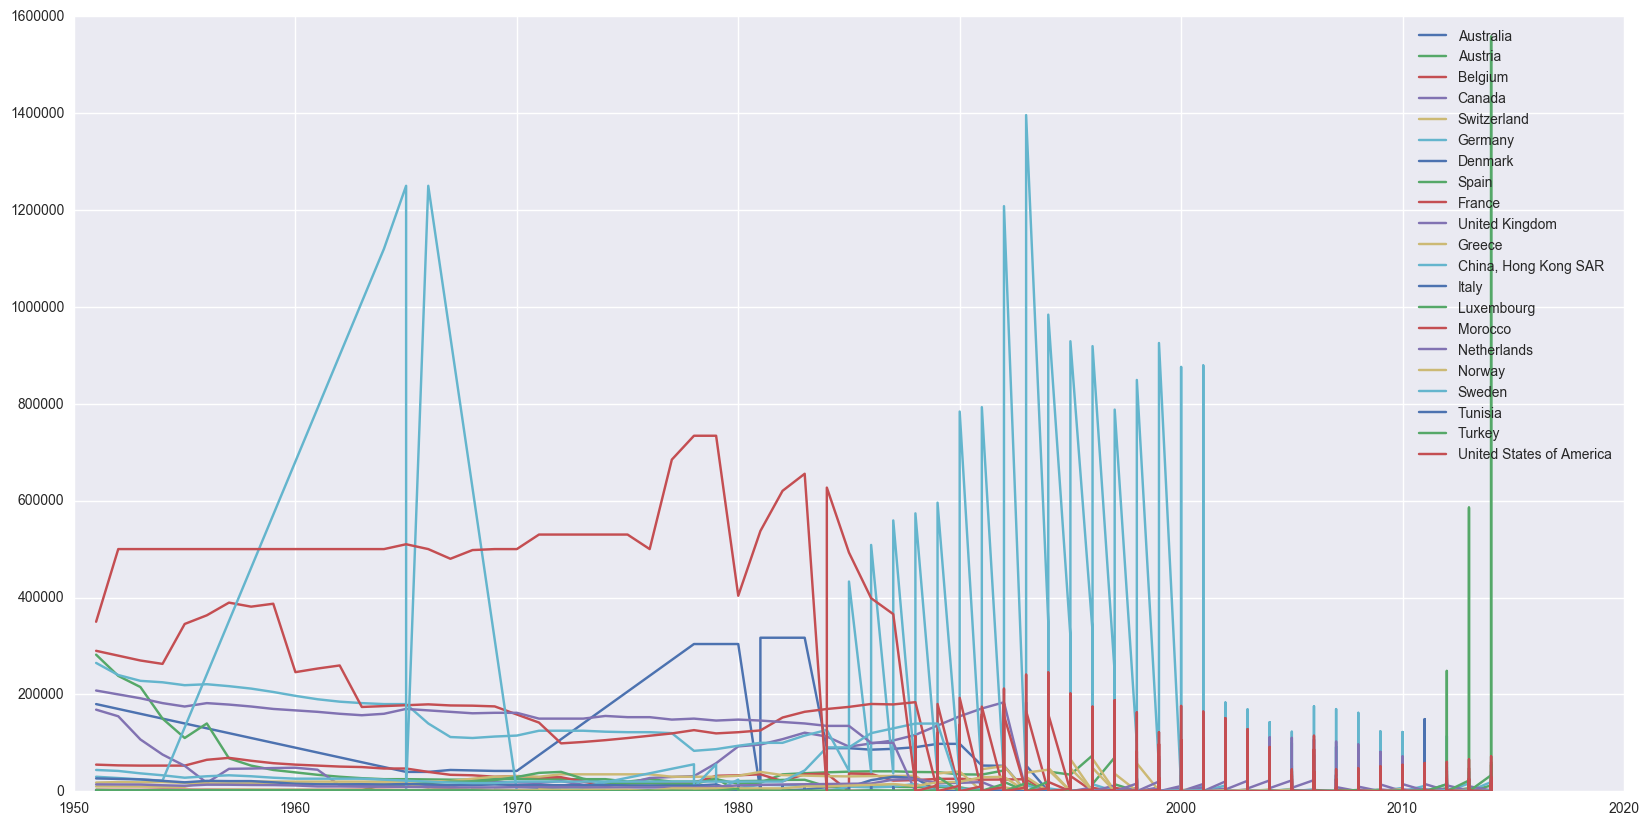

In [18]:
plot_all_countries(data_2,5000000)

# Autoregression model

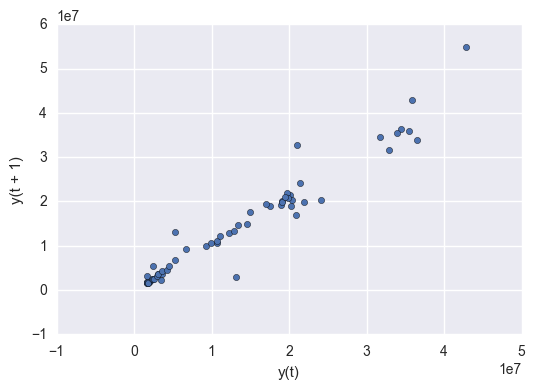

In [19]:
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot
lag_plot(by_year['Value'])
pyplot.show()

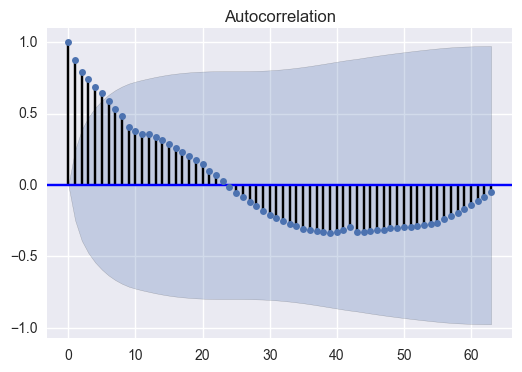

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(by_year['Value'])
plt.show()

In [21]:
def auto_regression(data_set = by_year,col ='Value'):
    from statsmodels.tsa.ar_model import AR
    from sklearn.metrics import mean_squared_error
    series = data_set['Value']
    # split dataset
    X = series.values
    train, test = X[1:len(X)-6], X[len(X)-6:]
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot results
    plt.plot(range(len(X)),X)
    plt.plot(range(len(X)-6,len(X)),test)
    plt.plot(range(len(X)-6,len(X)),predictions, color='red')
    plt.show()

In [22]:
# plt.plot(range(len(X)-6,len(X)),test)
# plt.plot(range(len(X)-6,len(X)),predictions, color='red')
# plt.show()

In [ ]:
by_year

Lag: 10
Coefficients: [  7.80253698e+05   7.88467909e-01   1.07212009e-01  -1.98773067e-01
   1.59625489e-01  -1.50151079e-01   3.61612598e-01  -1.45263055e-01
   1.75125540e-01  -2.21568452e-01   1.71913814e-01]
predicted=30405539.563075, expected=36466053.000000
predicted=31832923.588301, expected=33924438.000000
predicted=28958904.108646, expected=35441863.000000
predicted=33793842.647498, expected=35847933.000000
predicted=32849708.538150, expected=42865397.000000
predicted=37370777.136412, expected=54937556.000000
Test MSE: 82709672303959.703


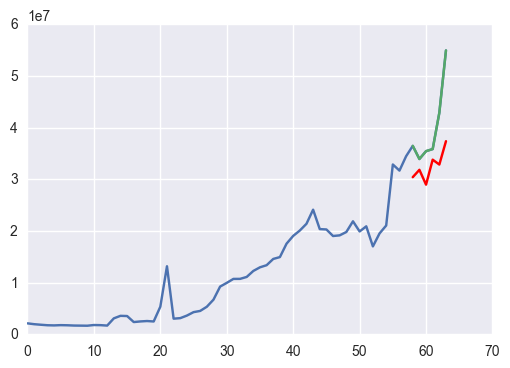

In [23]:
auto_regression(by_year,'Value')

In [24]:
# plt.plot(scaler.inverse_transform(dataset),'k')
# plt.plot(trainPredictPlot,'b')
# plt.plot(testPredictPlot,'r')
# plt.show()

## trying an LSTM again

In [25]:
## For total refugee values over the time

In [26]:
def lstm_time_series(data_set = by_year,col="Value"):
    import numpy
    import matplotlib.pyplot as plt
    from pandas import read_csv
    import math
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return numpy.array(dataX), numpy.array(dataY)
    # fix random seed for reproducibility
    numpy.random.seed(7)
    # load the dataset
    dataframe = data_set[['Value']]
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 3
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=20, batch_size=2, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset),'k')
    plt.plot(trainPredictPlot,'b')
    plt.plot(testPredictPlot,'r')
    plt.show()

In [27]:
lstm_time_series(data_2,'Value')

Using TensorFlow backend.


Epoch 1/20
628s - loss: 6.4375e-05
Epoch 2/20
Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1118, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 300, in wrapped
    return f(*args, **kwargs)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 345, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "//anaconda/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "//anaconda/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "//anaconda/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "//anaconda/lib/python2.7

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

## Looking at a single country

In [29]:
def one_country(data,country):
    #for a single country get everything
    country_df = data[data['Origin'] == country].groupby('Year').sum().reset_index()
    country_df.plot('Year','Value')
    return(country_df)

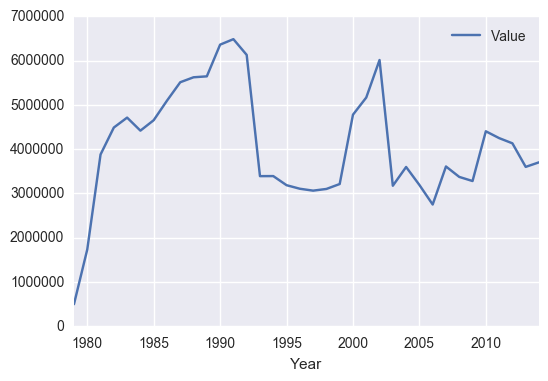

In [30]:
afg_df = one_country(data_2,'Afghanistan')

In [32]:
afg_df

,Year,Value
0,1979,500000.0
1,1980,1734921.0
2,1981,3879984.0
3,1982,4488754.0
4,1983,4713165.0
5,1984,4418871.0
6,1985,4654343.0
7,1986,5095453.0
8,1987,5511740.0
9,1988,5623642.0


In [ ]:
# data_2[data_2['Country / territory of asylum/residence'] == 'Afghanistan'].groupby('Year').sum().plot()

Epoch 1/20
2s - loss: 0.5232
Epoch 2/20
0s - loss: 0.4909
Epoch 3/20
0s - loss: 0.4579
Epoch 4/20
0s - loss: 0.4261
Epoch 5/20
0s - loss: 0.3958
Epoch 6/20
0s - loss: 0.3661
Epoch 7/20
0s - loss: 0.3385
Epoch 8/20
0s - loss: 0.3097
Epoch 9/20
0s - loss: 0.2840
Epoch 10/20
0s - loss: 0.2584
Epoch 11/20
0s - loss: 0.2329
Epoch 12/20
0s - loss: 0.2095
Epoch 13/20
0s - loss: 0.1875
Epoch 14/20
0s - loss: 0.1662
Epoch 15/20
0s - loss: 0.1466
Epoch 16/20
0s - loss: 0.1286
Epoch 17/20
0s - loss: 0.1120
Epoch 18/20
0s - loss: 0.0965
Epoch 19/20
0s - loss: 0.0831
Epoch 20/20
0s - loss: 0.0725
Train Score: 1530670.89 RMSE
Test Score: 712017.20 RMSE


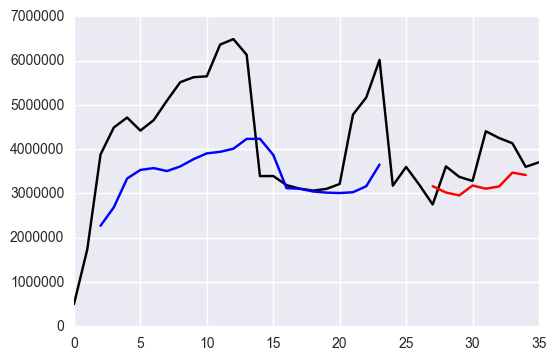

In [87]:
lstm_time_series(afg_df,'Value')

In [3]:
afg_df

NameError: name 'afg_df' is not defined

Lag: 9
Coefficients: [  1.98098686e+06   6.84275847e-01   1.84556056e-01  -3.22407692e-01
  -6.77841519e-02   2.70034723e-01  -2.95381562e-01  -2.48243594e-01
   4.70467811e-01  -1.50428507e-01]
predicted=4105793.490379, expected=3280950.000000
predicted=5125933.101189, expected=4404457.000000
predicted=4409316.900699, expected=4250315.000000
predicted=4976926.553383, expected=4132670.000000
predicted=4391980.992231, expected=3600396.000000
predicted=4165612.949493, expected=3703314.000000
Test MSE: 463212066531.958


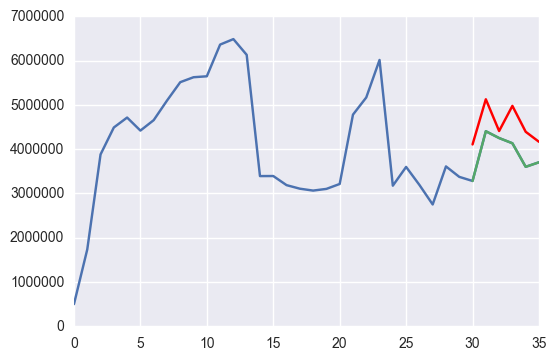

In [88]:
auto_regression(afg_df,'Value')

## Well, not working how I'd hope, but actually not that bad, all things considered.

In [ ]:
data_2

## adding more data

In [23]:
import sqlite3
conn = sqlite3.connect('./data/factbook.db')
c = conn.cursor()
q = 'select * from facts;'
c.execute(q)
df = pd.DataFrame(c.fetchall())

conn.close()

In [24]:
conn = sqlite3.connect('./data/factbook.db')
c = conn.cursor()
q = '''PRAGMA table_info(facts)'''

c.execute(q)
output= c.fetchall()

conn.close()

In [25]:
df.columns = [output[i][1] for i in range(len(output))]

In [86]:
df_merge = pd.merge(df,data_2,how ='inner',left_on='name',right_on ='Country / territory of asylum/residence' )#,left_on='name',right_on = 'Continent/Country of Nationality')

In [89]:
df_merge.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734,1990,Afghanistan,Various/Unknown,Refugees (incl. refugee-like situations),50.0
1,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734,1991,Afghanistan,Various/Unknown,Refugees (incl. refugee-like situations),38.0
2,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734,1992,Afghanistan,Tajikistan,Refugees (incl. refugee-like situations),60000.0
3,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734,1992,Afghanistan,Various/Unknown,Refugees (incl. refugee-like situations),25.0
4,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734,1993,Afghanistan,Afghanistan,Internally displaced persons,15000.0


In [93]:
df_merge = df_merge.groupby('Year').sum().reset_index()

In [94]:
df_merge.columns

Index([             u'Year',                u'id',              u'area',
               u'area_land',        u'area_water',        u'population',
       u'population_growth',        u'birth_rate',        u'death_rate',
          u'migration_rate',             u'Value'],
      dtype='object')

In [112]:

cols = [ u'area',
                                     u'area_land',
                                    u'area_water',
                                    u'population',
                             u'population_growth',
                                    u'birth_rate',
                                    u'death_rate',
                                u'migration_rate',
                                'Year',
                                        u'Value']
feature_cols = [ u'area',
                                     u'area_land',
                                    u'area_water',
                                    u'population',
                             u'population_growth',
                                    u'birth_rate',
                                    u'death_rate',
                                    'Year',
                                u'migration_rate']


In [100]:
df_model= df_merge[cols]
df_model.dropna(inplace = True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [101]:
# afg_df = one_country(df_aff_merge,'Afghanistan')

In [102]:
target = df_model['Value']
features = df_model[feature_cols]

In [103]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train,y_test = train_test_split(features,target,test_size = .3)

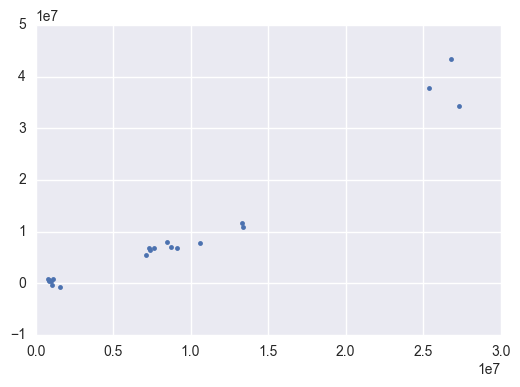

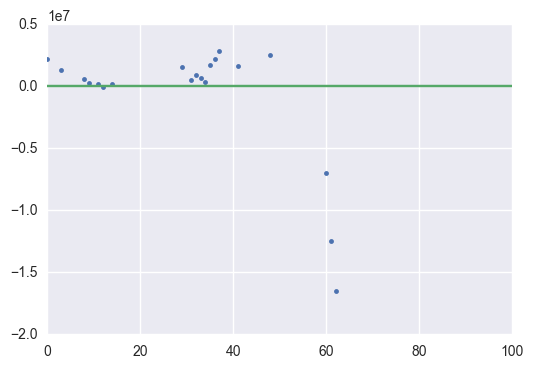

In [111]:
from sklearn.linear_model import LinearRegression
l_r = LinearRegression()
l_r.fit(X_train,y_train)
pred = l_r.predict(X_test)
plt.plot(y_test,pred,'.')
# plt.plot(np.linspace(0,400000),np.linspace(0,400000))
plt.show()
residuals = y_test - pred
plt.plot(residuals,'.')
plt.plot([0,100],[0,0])

This is not quite what I'm looking to do. I'm predicting the value of refugee given the information about a place. I'm making a regression model to predict this, but I want to do this in time. As in, I give it 2017, and it predicts the value for that singe country. I might have to put this on hold and work on other projects.

In [46]:
ls data/GFDD_csv/

GFDDCountry-Series.csv* GFDDData.csv*           GFDDSeries.csv*
GFDDCountry.csv*        GFDDFootNote.csv*


In [47]:
pd.read_csv('data/GFDD_csv/GFDDData.csv').head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,East Asia & Pacific (developing only),EAP,5-bank asset concentration,GFDD.OI.06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,East Asia & Pacific (developing only),EAP,Account at a formal financial institution (% a...,GFDD.AI.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.77,NaN,NaN,35.95,NaN,NaN
2,East Asia & Pacific (developing only),EAP,Account used for business purposes (% age 15+),GFDD.AI.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.50,NaN,NaN,NaN,NaN,NaN
3,East Asia & Pacific (developing only),EAP,Account used to receive government payments (%...,GFDD.AI.09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.53,NaN,NaN,NaN,NaN,NaN
4,East Asia & Pacific (developing only),EAP,Account used to receive remittances (% age 15+),GFDD.AI.10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.07,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,Ranking,Unnamed: 2,Economy,US dollars),Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,USA,1,NaN,United States,"18,569,100",NaN
3,CHN,2,NaN,China,"11,199,145",NaN
4,JPN,3,NaN,Japan,"4,939,384",NaN
